In [1]:
import os
from typing import Annotated, TypedDict, Literal, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from dotenv import load_dotenv  
load_dotenv() 

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [2]:
## Defining the State schema
class AgentState(MessagesState):
    next_agent: str ## The next agent to call

In [3]:
@tool
def search_web(query: str) -> str:
    """Search the web for a query."""
    search = TavilySearch(max_results=3)
    results = search.invoke(query)
    return results


@tool 
def write_summary(content: str) -> str:
    """Write a summary of the content."""
    summary = f"Summary of the content: \n\n{content[:500]}..."
    return summary

In [4]:
llm = ChatGroq(model="llama3-8b-8192")

In [5]:
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage

def research_agent(state: AgentState):
    """ Research agent that searches the Information. """

    messages = state['messages']

    system_msg = SystemMessage(content = "You are a research assistant. Use the seach_web tool to find information about the topic that the user is asking about.")

    ### Call the llm with tools
    researcher_llm = llm.bind_tools([search_web])
    response = researcher_llm.invoke(
        [system_msg] + messages,
    )

    ## return the response
    return {
        "messages": [response],
        "next_agent": "writer"
    }

In [6]:
def writer_agent(state: AgentState):
    """ Writer agent that writes a summary of the information. """

    messages = state['messages']

    system_msg = SystemMessage(content = "You are a technical writer. Review the Conversation and create a clear, concise summary of the findings.")

    ### Call the llm with tools
    response = llm.invoke(
        [system_msg] + messages,
    )

    ## return the response
    return {
        "messages": [response],
        "next_agent": "end"
    }

In [7]:
from langgraph.prebuilt import ToolNode
def execute_tools(state : AgentState):
    """ Execute any pending tool calls. """

    messages = state['messages']
    
    last_message = messages[-1]

    if hasattr(last_message, "tools_calls") and last_message.tools_calls:
        
        tool_node = ToolNode([search_web, write_summary])
        response = tool_node.invoke(state)
        return response

    return state

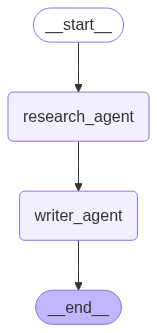

In [8]:
workflow = StateGraph(AgentState) 

workflow.add_node("research_agent", research_agent)
workflow.add_node("writer_agent", writer_agent)

workflow.set_entry_point("research_agent")
workflow.add_edge("research_agent", "writer_agent")
workflow.add_edge("writer_agent", END)

builder = workflow.compile()

builder

In [12]:
response = builder.invoke({"messages": "Research About the usecase of Agentic AI in Software Development?"})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Research About the usecase of Agentic AI in Software Development?
================================== Ai Message ==================================
Tool Calls:
  search_web (f8zzjh7ed)
 Call ID: f8zzjh7ed
  Args:
    query: Agentic AI in Software Development
================================== Ai Message ==================================

 

Summary:

The research on the use case of Agentic AI in software development reveals that Agentic AI, a type of artificial intelligence that enables machines to make decisions independently, has the potential to revolutionize the software development process. The study highlights the following key findings:

1. **Improved Efficiency**: Agentic AI can automate repetitive and time-consuming tasks, allowing developers to focus on higher-level tasks that require creativity and critical thinking.
2. **Enhanced Collaboration**: Agentic AI can facilitate collaboration between